In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import dask.dataframe as dd
from multiprocessing import cpu_count
nCores = cpu_count()
from dask.diagnostics import ProgressBar
ProgressBar().register()

import matplotlib
#%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm
#import os
import pickle
import time
from sklearn.model_selection import GridSearchCV, cross_val_score

#import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from joblib import Parallel, delayed
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from bayes_opt.event import Events
#from keras.models import Sequential, load_model
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [3]:
# create datetime object
def time_fixer(data):
    datetime_real = (datetime(int(data.loc['YEAR']), int(data.loc['MO']), int(data.loc['DY']), hour=int(data.loc['HR'])))

    return datetime_real

In [4]:
data=pd.read_csv('POWER_Point_Hourly_20010101_20220401_012d0000N_037d2500E_LST.csv', header=13)

In [5]:
data['datetime'] = dd.from_pandas(data, npartitions = nCores).\
                    map_partitions(
                    lambda data_mini : data_mini.apply(
                    lambda x: time_fixer(x), axis=1)).compute()
data.set_index('datetime', inplace=True)

[########################################] | 100% Completed | 16.17 s


In [6]:
df=data.copy()
df

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,SZA,ALLSKY_KT
datetime,,,,,,,,,,,,,,
2001-01-01 02:00:00,2001,1,1,2,0.00,17.20,6.66,49.81,0.0,81.12,2.81,323.35,-999.00,-999.00
2001-01-01 03:00:00,2001,1,1,3,0.00,17.48,6.04,46.88,0.0,81.13,1.75,339.95,-999.00,-999.00
2001-01-01 04:00:00,2001,1,1,4,0.00,17.08,5.70,46.94,0.0,81.17,1.07,25.07,-999.00,-999.00
2001-01-01 05:00:00,2001,1,1,5,0.00,16.32,5.88,49.94,0.0,81.21,1.43,81.52,-999.00,-999.00
2001-01-01 06:00:00,2001,1,1,6,87.11,16.82,6.58,50.81,0.0,81.26,2.15,101.31,82.25,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01 19:00:00,2022,4,1,19,0.00,25.53,7.72,32.44,0.0,81.14,4.26,63.76,-999.00,-999.00
2022-04-01 20:00:00,2022,4,1,20,0.00,24.87,8.48,35.44,0.0,81.20,4.89,63.93,-999.00,-999.00
2022-04-01 21:00:00,2022,4,1,21,0.00,24.25,9.06,38.38,0.0,81.24,5.63,74.56,-999.00,-999.00


In [7]:
def create_lagged_features(data, n_lags):
    lagged_data = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        lagged_data[f'lag_{i}'] = data.shift(i)
    return lagged_data.dropna()

n_lags = 5
lagged_data = create_lagged_features(data['ALLSKY_SFC_SW_DWN'], n_lags)
lagged_data = pd.concat([data, lagged_data], axis=1).dropna()
lagged_data

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,SZA,ALLSKY_KT,lag_5,lag_4,lag_3,lag_2,lag_1
datetime,,,,,,,,,,,,,,,,,,,
2001-01-01 07:00:00,2001,1,1,7,324.49,18.98,5.88,42.38,0.0,81.32,2.59,101.31,69.42,0.66,0.00,0.00,0.00,0.00,87.11
2001-01-01 08:00:00,2001,1,1,8,554.05,21.08,4.45,33.94,0.0,81.35,2.11,80.64,57.37,0.73,0.00,0.00,0.00,87.11,324.49
2001-01-01 09:00:00,2001,1,1,9,738.85,22.44,3.58,29.38,0.0,81.33,1.10,82.22,46.80,0.77,0.00,0.00,87.11,324.49,554.05
2001-01-01 10:00:00,2001,1,1,10,841.14,23.38,2.83,26.25,0.0,81.28,0.22,216.47,38.98,0.77,0.00,87.11,324.49,554.05,738.85
2001-01-01 11:00:00,2001,1,1,11,895.08,24.10,2.98,25.44,0.0,81.22,1.31,259.36,35.74,0.78,87.11,324.49,554.05,738.85,841.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01 19:00:00,2022,4,1,19,0.00,25.53,7.72,32.44,0.0,81.14,4.26,63.76,-999.00,-999.00,560.27,353.17,152.38,22.98,0.00
2022-04-01 20:00:00,2022,4,1,20,0.00,24.87,8.48,35.44,0.0,81.20,4.89,63.93,-999.00,-999.00,353.17,152.38,22.98,0.00,0.00
2022-04-01 21:00:00,2022,4,1,21,0.00,24.25,9.06,38.38,0.0,81.24,5.63,74.56,-999.00,-999.00,152.38,22.98,0.00,0.00,0.00


In [8]:
# Obtained from the experiment-1 feature selection result.
selected_features=['MO', 'HR', 'T2M', 'RH2M', 'SZA', 'ALLSKY_KT', 'lag_5', 'lag_4',
       'lag_2', 'lag_1']

In [9]:
X=lagged_data[selected_features].values
y=lagged_data['ALLSKY_SFC_SW_DWN'].values
y=y.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Define the window size 
window_size = 24

split = int(len(X) * 0.8)

X_tr = X[:split]
y_tr = y[:split]

X_test = X[split:]
y_test = y[split:]

X_tr.shape, y_tr.shape

((149005, 10), (149005, 1))

In [10]:
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=4, test_size=window_size*90)
def svr_model(val_c, e):
        score=(cross_val_score(SVR(C=val_c, epsilon=e), X_tr, y_tr, cv=tscv, scoring='neg_root_mean_squared_error'))
        avg=np.mean(score)
        return avg

In [11]:
# Bayesian optimization
def optimize_svr(data, pbounds):
    optimizer = BayesianOptimization(
        f=lambda val_c, e: svr_model(val_c, e),
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )
    
    # Create a JSONLogger and attach it to the optimizer to record progress.
    logger = JSONLogger(path="log.json", reset=False)
    # to continue from the previous progress uncomment the following line.
    # optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    
    optimizer.maximize(init_points=3, n_iter=5)
    return optimizer.max

In [ ]:
start=datetime.now()
bounds = {'val_c': (0.01, 1), 'e': (0.001,1)}

best_params = optimize_svr(X_tr, bounds)
end=datetime.now()
print("Total Time taken:", end - start)

In [13]:
# Random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform

# Define the parameter distribution to sample from.
param_dist = {'C': uniform(0, 10), 'gamma': uniform(0, 10), 'kernel': ['linear', 'rbf']}

# Create an instance of the SVR estimator
svr = SVR()

btss = TimeSeriesSplit(n_splits=5)
from functools import partial
from sklearn.metrics import make_scorer

root_mean_squared_error = partial(mean_squared_error, squared=False)
rms_error = make_scorer(root_mean_squared_error)

# Create a RandomizedSearchCV object with the SVR estimator and parameter distribution
random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, scoring=rms_error, cv=btss, verbose=3)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_tr, y_tr)

# Print the best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=1.4391706085541722, gamma=0.6375025379977473, kernel=rbf;, score=0.045 total time=   1.1s
[CV 2/5] END C=1.4391706085541722, gamma=0.6375025379977473, kernel=rbf;, score=0.045 total time=   0.8s
[CV 3/5] END C=1.4391706085541722, gamma=0.6375025379977473, kernel=rbf;, score=0.045 total time=   0.8s
[CV 4/5] END C=1.4391706085541722, gamma=0.6375025379977473, kernel=rbf;, score=0.046 total time=   0.9s
[CV 5/5] END C=1.4391706085541722, gamma=0.6375025379977473, kernel=rbf;, score=0.047 total time=   0.8s
[CV 1/5] END C=1.8069943322425752, gamma=2.189570674730823, kernel=linear;, score=0.078 total time=   8.4s
[CV 2/5] END C=1.8069943322425752, gamma=2.189570674730823, kernel=linear;, score=0.080 total time=   7.9s
[CV 3/5] END C=1.8069943322425752, gamma=2.189570674730823, kernel=linear;, score=0.078 total time=   8.5s
[CV 4/5] END C=1.8069943322425752, gamma=2.189570674730823, kernel=linear;, score=0.076 total

In [14]:
# Grid search
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

# Define the hyperparameters to search over
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}

# Create an SVM classifier
svm = SVR()

# Create a GridSearchCV object with parallelism enabled
with parallel_backend('multiprocessing', n_jobs=-1):
    grid_search = GridSearchCV(svm, param_grid, scoring=rms_error, cv=btss, verbose=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_tr, y_tr)

# Print the best hyper and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.083 total time=   9.8s
[CV 2/5] END .................C=0.1, gamma=0.01;, score=0.084 total time=   9.9s
[CV 3/5] END .................C=0.1, gamma=0.01;, score=0.084 total time=   9.5s
[CV 4/5] END .................C=0.1, gamma=0.01;, score=0.083 total time=   9.0s
[CV 5/5] END .................C=0.1, gamma=0.01;, score=0.083 total time=   9.7s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.069 total time=   2.6s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.068 total time=   2.7s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.068 total time=   2.7s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.068 total time=   2.8s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.066 total time=   2.8s
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.048 total time=   0.9s
[CV 2/5] END ....................C=0.1, gamma=1;,

In [24]:
model=SVR(kernel='rbf', C=0.1, epsilon=0.01)
model.fit(X_tr, y_tr)
scores= model.score(X_test, y_test)
print("Score: %.2f%%" % (scores * 100))

Score: 99.32%


In [14]:
pred = model.predict(X_eval)
pred[pred < 0] = 0

In [ ]:
# Inverse transform data
inv_data = pd.DataFrame(scaler.inverse_transform(scaled), index=scaled.index, columns=scaled.columns)

In [ ]:
dt=scaled.iloc[split+1+num:].copy()
dd = pd.concat([dt, pd.DataFrame(pred, columns=['pred'], index=dt.index)], axis=1)
pred=dd['pred']
original=dd['ALLSKY_SFC_SW_DWN']
dt.iloc[:, 0]=pred

In [ ]:
inv_yhat = pd.DataFrame(scaler.inverse_transform(dt), index=dt.index, columns=dt.columns).iloc[:, 0]
inv_test=inv_data.iloc[split+1+num:, 0]

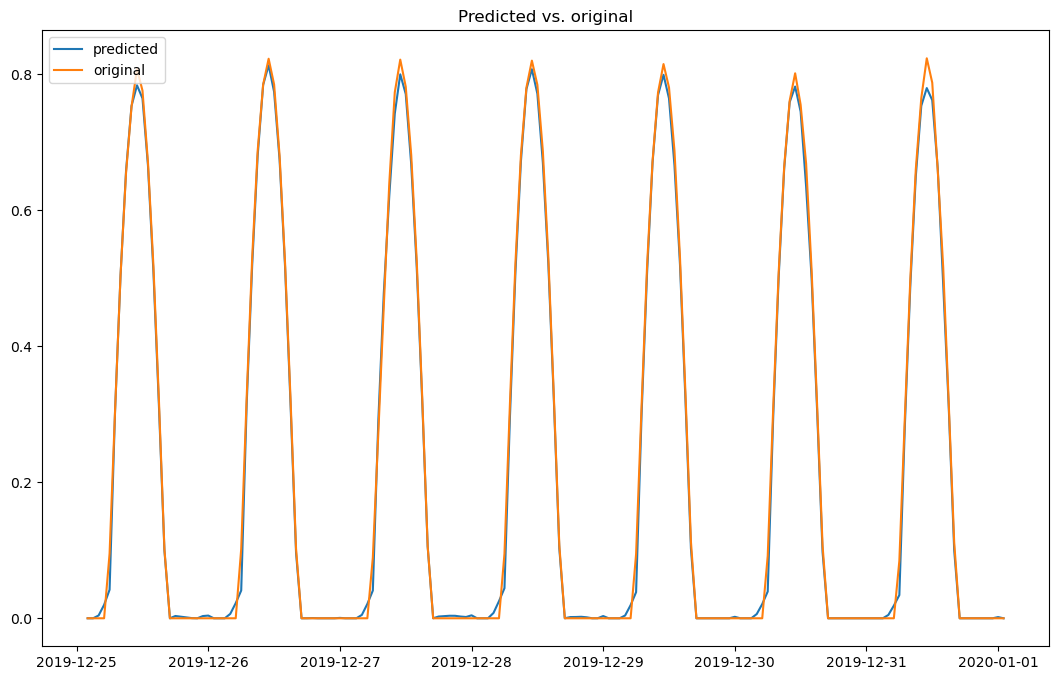

In [18]:
days=7*24
plt.plot(pred[-days:], label='predicted')
plt.plot(original[-days:], label='original')
plt.legend()
plt.title('Predicted vs. original')
    
plt.show()

In [23]:
rmse = mean_squared_error(pred, y_eval, squared=False)
rmse

0.026507579246403252

In [31]:
r2_score(y_eval, pred)

0.9910233421790201

In [19]:
inv_yhat.rename('predicted', inplace=True)
inv_test.rename('real', inplace=True)
result = pd.concat([inv_yhat, inv_test], axis=1)
result

,predicted,real
datetime,,
2019-03-29 12:00:00,853.564951,889.84
2019-03-29 13:00:00,738.050284,794.02
2019-03-29 14:00:00,604.203483,604.16
2019-03-29 15:00:00,399.460134,407.30
2019-03-29 16:00:00,191.549586,195.14
...,...,...
2019-12-31 21:00:00,0.000000,0.00
2019-12-31 22:00:00,0.000000,0.00
2019-12-31 23:00:00,0.000000,0.00


In [33]:
filename = 'SVR_C-0.1_eps-0.01.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

In [41]:
model_results=[]
model_results_dict = {}
model_results_dict['model name'] = 'SVR_C-1_eps-0.01.sav'
model_results_dict['score(%)'] = scores*100
model_results_dict['rmse(%)'] = rmse*100
model_results.append(model_results_dict)

# Reads in old results and concats with new results

new_res_df = pd.DataFrame(model_results)
old_res_df = pd.read_csv('trained_svr.csv', index_col=0)
res_df = pd.concat([old_res_df, new_res_df], axis=0, sort=False).reset_index(drop=True)
res_df.to_csv('trained_svr.csv')

In [13]:
#load the model from disk
model = pickle.load(open('SVR_C-1_eps-0.01.sav', 'rb'))